In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
d13 = pd.read_csv('thads2013n.txt')
df = pd.read_csv('tAHS2013N.csv')
len(df)

C:\Users\zhutk\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1375) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


40710

In [2]:
df.columns = [a.upper() for a in df.columns]
d13.columns = [a.upper() for a in d13.columns]

In [3]:
df = df[['CONTROL','CMSA','SMSA','NUNIT2','ELEV','SHARAT','SHARFR','GARAGE','PORCH','NOSTEP',
    'DINING','LAUNDY','LOT','EBAR','MOBILTYP','ACCESS','CLIMB','INCP','CELLAR','FLOORS','UNITSF','KITCH',
    'BATHS','SHARPF','KITCHEN','KEXCLU','BSINK','TOILET','TUB','PTDISBUS','PTDISRAIL','PTDISSUB','PTDISSHUT','DRUGSTORE',
   'GROCERY','EWATER','WFPROP','NHDBLDSUD','NHDBLDSUA','NHDBLDMU','NHDBLDMH','ECOM1','ECOM2','EBARCL','EABAN','EJUNK','EGREEN',
   'EHEIGHT','EPRKG','EROAD','SATPOL','CEFTRUSTED','HEQUIP','FPLWK','GASPIP','AIR','AIRSYS','WATER','SEWDIS','WFUEL','REFR',
   'DISH','SINK','WASH','DRY','BURNER','COOK','DISPL','OVEN']]

In [4]:
features = ['SMSA','NUNIT2','ELEV','SHARAT','SHARFR','GARAGE','PORCH','NOSTEP',
    'DINING','LAUNDY','LOT','EBAR','MOBILTYP','ACCESS','CLIMB','INCP','CELLAR','FLOORS','UNITSF','KITCH',
    'BATHS','SHARPF','KITCHEN','KEXCLU','BSINK','TOILET','TUB','PTDISBUS','PTDISRAIL','PTDISSUB','PTDISSHUT','DRUGSTORE',
   'GROCERY','EWATER','WFPROP','NHDBLDSUD','NHDBLDSUA','NHDBLDMU','NHDBLDMH','ECOM1','ECOM2','EBARCL','EABAN','EJUNK','EGREEN',
   'EHEIGHT','EPRKG','EROAD','SATPOL','CEFTRUSTED','HEQUIP','FPLWK','GASPIP','AIR','AIRSYS','WATER','SEWDIS','WFUEL','REFR',
   'DISH','SINK','WASH','DRY','BURNER','COOK','DISPL','OVEN','NUNITS','BUILT']

In [5]:
df = df.merge(d13,on = 'CONTROL')
len(df)

30953

In [6]:
for a in df.columns:
    if type(df.loc[1,a]) == str:
        df.loc[:,a] = df[a].str.strip("'")
        
cols = [c for c in df.columns if c[:3] != 'FMT']
df = df[cols]

df.columns = [a.upper() for a in df.columns]

In [7]:
#The new AFFORDABLE variable represents whether or not a property would be affordable or not at area median income.
df.loc[df.COSTMEDRELAMICAT.isin([1,2,3,4,5]),'AFFORDABLE']=1
df.loc[df.COSTMEDRELAMICAT.isin([6,7]),'AFFORDABLE']=0
df.AFFORDABLE.value_counts()

1.0    23903
0.0     7050
Name: AFFORDABLE, dtype: int64

In [8]:
df.isin([-9,'-9']).sum().sort_values(ascending=False).head(20)

ASSISTED            20267
INCRELFMRCAT         2183
INCRELAMIPCT         2183
INCRELFMRPCT         2183
INCRELPOVCAT         2183
COST08RELPOVPCT      2183
COST08RELPOVCAT      2183
INCRELPOVPCT         2183
AGE1                 2183
INCRELAMICAT         2183
COST12RELPOVPCT      2183
COST06RELPOVCAT      2183
COST12RELPOVCAT      2183
BURDEN               2183
APLMED               2183
COSTMEDRELPOVPCT     2183
COSTMEDRELPOVCAT     2183
TOTSAL               2183
COST06RELPOVPCT      2183
INCP                    2
dtype: int64

In [9]:
df.drop('ASSISTED',axis=1,inplace=True)
#Assisted is only in HADS not AHS and its meaning is not clear.  The goal is to predict based on the features of the property.

In [10]:
#Investigating the 2183 rows.
df[df.AGE1 ==-9].VACANCY.value_counts()
#They are all vacant properties (no -6 values)

1    1317
3     519
5     155
2     115
4      77
Name: VACANCY, dtype: int64

In [11]:
len(df[df.VACANCY.isin([1,2,3,4,5])])

2183

In [12]:
df[df.AGE1==-9].VALUE.value_counts().head(10)
#Most not applicable values anyway so may as well drop these row

-6         1509
 150000      34
 60000       31
 40000       31
 70000       29
 100000      26
 200000      25
 30000       25
 160000      23
 80000       23
Name: VALUE, dtype: int64

In [13]:
df = df.loc[df.AGE1!=-9,:]
df.isin([-9,'-9']).sum().sort_values(ascending=False).head()

INCP          1
EWATER        0
CEFTRUSTED    0
SATPOL        0
EROAD         0
dtype: int64

In [14]:
df = df[~df.INCP.isin(['-9'])]

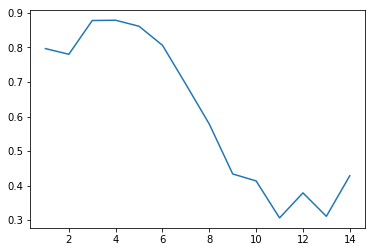

In [15]:
plt.plot(df[['AFFORDABLE','ROOMS']].groupby('ROOMS').mean())
plt.show()

In [16]:
df.COSTMEDRELAMICAT.value_counts().sort_index()

1    3069
2    5861
3    3881
4    5820
5    3469
6    2212
7    4457
Name: COSTMEDRELAMICAT, dtype: int64

In [17]:
print len(df)
df.dropna(axis=0,inplace=True)
print len(df)

28769
28768


In [18]:
from sklearn.ensemble import RandomForestClassifier
RFC_AFF = RandomForestClassifier(n_jobs=-1,n_estimators=300,max_features=.15,max_depth=20)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
X = df[features]
y = df.AFFORDABLE
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size = .3)
RFC_AFF.fit(xtrain,ytrain)
RFC_AFF.score(xtest, ytest)

0.81879272390221292

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest,RFC_AFF.predict(xtest))

array([[ 792, 1243],
       [ 321, 6275]])


mis_cls = [train 
           for test, truth, train in 
           zip(xtest, ytest, xtrain) 
           if RFC.predict(test) != truth]

In [20]:
pd.Series(RFC_AFF.feature_importances_,X.columns).sort_values(ascending=False)

UNITSF        0.137772
SMSA          0.071034
BATHS         0.069050
BUILT         0.064825
LOT           0.061095
FPLWK         0.046097
FLOORS        0.038445
DISH          0.028086
CELLAR        0.027818
HEQUIP        0.025380
WFUEL         0.023233
NUNITS        0.020621
DINING        0.019862
CEFTRUSTED    0.018328
INCP          0.016972
DISPL         0.016593
NOSTEP        0.015561
GASPIP        0.015479
LAUNDY        0.014715
CLIMB         0.013990
EROAD         0.012776
PTDISSUB      0.011818
AIRSYS        0.011580
GARAGE        0.011515
AIR           0.011157
EGREEN        0.009360
NUNIT2        0.009119
PORCH         0.008125
ELEV          0.007934
ECOM1         0.007746
                ...   
GROCERY       0.006530
EPRKG         0.006521
EWATER        0.006509
EABAN         0.006228
NHDBLDSUA     0.006137
EBAR          0.006097
DRY           0.005285
NHDBLDMU      0.004998
PTDISRAIL     0.004825
EJUNK         0.004536
WASH          0.004276
SHARFR        0.003595
SHARAT     

In [21]:
new_features = ['SMSA','UNITSF','BUILT','BATHS','LOT','FPLWK','FLOORS','CELLAR','DISH','HEQUIP','WFUEL','DINING','NUNITS',
               'CEFTRUSTED','DISPL','INCP','GASPIP','NOSTEP','LAUNDY','CLIMB','EROAD','GARAGE','AIRSYS','AIR']
X = df[new_features]
y = df.AFFORDABLE
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)
RFC_AFF.fit(X_train,y_train)
RFC_AFF.score(X_test, y_test)

0.82377476538060479

In [22]:
RFC_FMR = RandomForestClassifier(n_jobs=-1,n_estimators=300,max_features=.15,max_depth=20)
X = df[new_features]
y = df.COSTMEDRELFMRCAT
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_FMR.fit(xtrain,ytrain)
RFC_FMR.score(xtest,ytest)

0.62066967906383963

In [23]:
RFC_POV = RandomForestClassifier(n_jobs=-1,n_estimators=300,max_features=.15,max_depth=20)
X = df[new_features]
y = df.COSTMEDRELPOVCAT
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_POV.fit(xtrain,ytrain)
RFC_POV.score(xtest,ytest)

0.67836867106940102

In [24]:
df.replace(['-7','-8'],'-6',inplace=True)

In [25]:
df.SMSA.value_counts()
cities = {'2160': 'Detroit', '6160': 'Philadelphia', '5600': 'New York City', '4480': 'Los Angeles', '1600': 'Chicago', '8840': 'Washington DC', '3360': 'Houston',
'7320': 'San Diego', '0360': 'Anaheim', '1120': 'Boston', '1920': 'Dallas', '5775': 'Oakland', '6200': 'Phoenix', '5120': 'Minneapolis-Saint Paul',
'7600': 'Seattle'}
dl = df[df.SMSA.isin(['2160','6160','5600','4480','1600','8840','3360','7320','0360','1120','1920','5775','6200','5120','7600'])]
dl.loc[:,'CITY'] = dl['SMSA'].map(cities)

C:\Users\zhutk\Anaconda2\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zhutk\Anaconda2\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


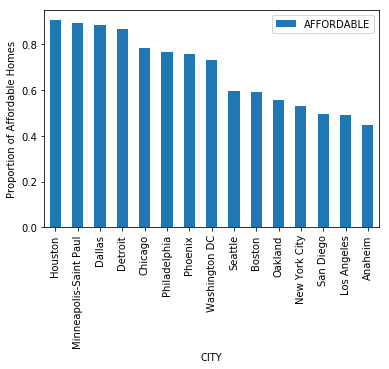

In [26]:
r = dl[['AFFORDABLE','CITY']].groupby('CITY').mean().sort_values('AFFORDABLE', ascending=False)
r.plot(kind='bar')
plt.ylabel('Proportion of Affordable Homes')
plt.show()

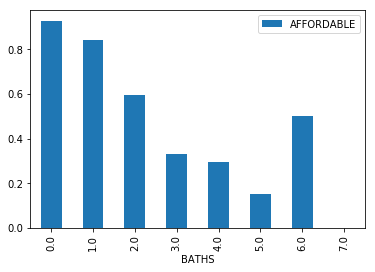

In [27]:
dl[['AFFORDABLE','BATHS']].groupby('BATHS').mean().plot(kind='bar')
plt.show()

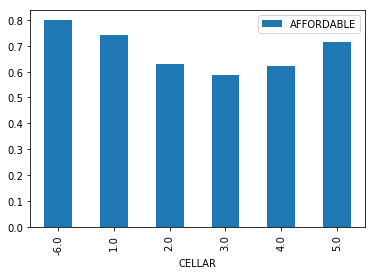

In [28]:
dl[['AFFORDABLE','CELLAR']].groupby('CELLAR').mean().plot(kind='bar')
plt.show()

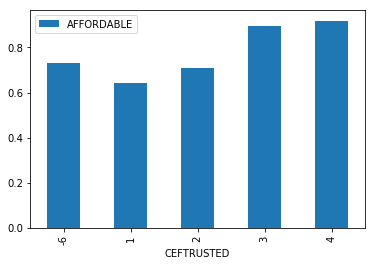

In [29]:
dl[['AFFORDABLE','CEFTRUSTED']].groupby('CEFTRUSTED').mean().plot(kind='bar')
plt.show()

In [30]:
dl.loc[dl.CEFTRUSTED.isin(['1','2']),'TRUST'] = 'Safe'
dl.loc[dl.CEFTRUSTED.isin(['3','4']),'TRUST'] = 'Unsafe'
dl.loc[dl.CEFTRUSTED.isin(['-6']),'TRUST'] = -6
dl[['AFFORDABLE','CEFTRUSTED']].groupby('CEFTRUSTED').sum()

,AFFORDABLE
CEFTRUSTED,
-6,3325.0
1,929.0
2,1196.0
3,340.0
4,180.0


In [31]:
stat = dl[dl.TRUST.isin(['Safe','Unsafe'])]
means = stat[['AFFORDABLE','TRUST']].groupby('TRUST').mean()
stds = stat[['AFFORDABLE','TRUST']].groupby('TRUST').std()
counts = stat[['AFFORDABLE','TRUST']].groupby('TRUST').count()
diff = (means.iloc[1].values - means.iloc[0].values)
print 'Unsafe Neighborhoods are {}% more affordable than safe neighborhoods.'.format(diff[0]*100)

Unsafe Neighborhoods are 22.5594858721% more affordable than safe neighborhoods.


In [32]:
comb_std = ((stds.values[0]**2)/counts.values[0]+(stds.values[1]**2)/counts.values[1])**.5
z_score = diff/comb_std
p_value = scipy.stats.norm.sf(abs(z_score)) #one-sided
print 'Under the null hypothesis, this result occurs with probability {}'.format(p_value[0])

Under the null hypothesis, this result occurs with probability 5.15858976825e-52


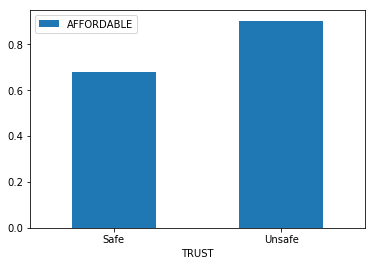

In [33]:
dl.loc[dl.TRUST.isin(['Safe','Unsafe']),['AFFORDABLE','TRUST']].groupby('TRUST').mean().plot(kind='bar',rot=0)
plt.show()

In [34]:
dl[dl.INCP=='-6'].GARAGE.value_counts()

1     5129
-6      12
2        2
Name: GARAGE, dtype: int64

In [35]:
RFC_AFF = RandomForestClassifier(n_jobs=-1,n_estimators=300,max_features=.15,max_depth=20)
X = dl[features]
y = dl.AFFORDABLE
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_AFF.fit(xtrain,ytrain)
RFC_AFF.score(xtest, ytest)

0.82075090835688336

In [36]:
focus = pd.Series(RFC_AFF.feature_importances_,X.columns).sort_values(ascending=False).head(25)
focus.index.values

array(['UNITSF', 'SMSA', 'BUILT', 'BATHS', 'LOT', 'FPLWK', 'FLOORS',
       'DISH', 'CELLAR', 'NUNITS', 'HEQUIP', 'DINING', 'WFUEL', 'INCP',
       'DISPL', 'NOSTEP', 'CLIMB', 'CEFTRUSTED', 'GARAGE', 'LAUNDY', 'AIR',
       'GASPIP', 'AIRSYS', 'PTDISSUB', 'EROAD'], dtype=object)

In [37]:
foc = ['SMSA','BUILT','UNITSF','BATHS','LOT','FPLWK','FLOORS','DISH','CELLAR','NUNITS','HEQUIP','DINING','WFUEL','CEFTRUSTED',
       'INCP','DISPL','CLIMB','GARAGE','NOSTEP','LAUNDY']
RFC_aff = RandomForestClassifier(n_jobs=-1, n_estimators = 300)
X = dl[foc]
y = dl.AFFORDABLE
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=.3)
RFC_aff.fit(Xtrain,Ytrain)
RFC_aff.score(Xtest, Ytest)

0.80581348405329023

In [38]:
RFC_fmr = RandomForestClassifier(n_jobs=-1, n_estimators = 300)
X = dl[foc]
y = dl.COSTMEDRELFMRCAT
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_fmr.fit(xtrain,ytrain)
RFC_fmr.score(xtest, ytest)

0.63019781994348001

In [39]:
RFC_pov = RandomForestClassifier(n_jobs=-1, n_estimators = 300)
X = dl[foc]
y = dl.COSTMEDRELPOVCAT
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_pov.fit(xtrain,ytrain)
RFC_pov.score(xtest, ytest)


0.71174808235769071

In [40]:
def Affordable_Test():
    a = raw_input('Where is the unit located? 2160: Detroit, 6160: Philadelphia, 5600: New York City, 4480: Los Angeles, 1600: Chicago, 8840: Washington DC, 3360: Houston, 7320: San Diego, 0360: Anaheim, 1120: Boston, 1920: Dallas, 5775: Oakland, 6200: Phoenix, 5120: Minneapolis-Saint Paul, 7600: Seattle') 
    b = raw_input('What year was the unit built?')
    c = raw_input('How many square feet is the unit?')
    d = raw_input('Number of full bathrooms?')
    e = raw_input('How many square feet is the lot? Answer -6 if n/a')
    f = raw_input('Does the unit have a useable fireplace? 1 for yes 2 for no')
    g = raw_input('How many floors are in the unit?')
    h = raw_input('Does the unit have a  working dishwasher? 1 for yes, 2 for no')
    i = raw_input('Is this house build with 1: basement under the whole house, 2: basement under part of the house, 3:a crawl space, 4: On a concrete slab?')
    j = raw_input('How many apartments are in the building? answer 1 if not an apartment')
    k = raw_input('Is the unit heated by 1: Forced warm-air furnace with ducts and vents to individual rooms, 2: Steam or hot water system with radiators OR other system using steam or hot water, 3: Electric heat pump, 4: Built-in electric baseboard heating or electric coils in floors, ceilings, or walls, 5: Floor, wall, or other pipeless furnace built into the building')
    l = raw_input('How many dining Rooms in the unit?')
    m = raw_input('Water is heated using 1: Electricity, 2: Gas, LP gas (liquid propane(LP) same as bottled gas), 3: Fuel oil, 4: Kerosene or other liquid fuel, 5: Coal or coke, 6: Wood, 7: Solar energy')
    n = raw_input('People in the neighborhood surrounding the unit can be trusted 1: Strongly agree, 2: Somewhat agree, 3: Somewhat disagree, 4: Strongly disagree')
    o = raw_input('Is a driveway/lot/parking area off the street provided? 1 for yes, 2 for no')
    p = raw_input('Does the unit have a working garbage disposal? 1 for yes, 2 for no')
    q = raw_input('How many stories are there from the main entrance of the building to the main entrance of this apartment?')
    r = raw_input('Is a garage or carport included with this unit? 1 for yes, 2 for no')
    s = raw_input('Is it possible to enter this unit WITHOUT climbing up or down any steps or stairs? 1 for yes, 2 for no')
    t = raw_input('How many laundry, utility, or pantry rooms?')
   
    X = np.array([a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t]).reshape(1,-1)
    z = RFC_aff.predict((X))
    aa = RFC_fmr.predict((X))
    bb = RFC_pov.predict((X))
    if z == 0:
        print 'This unit is Not Affordable at Area Median Income'
    else:
        print 'This unit is Affordable at Area Median Income'
    if aa == 1:
        print 'This unit is Affordable at less than 50% of Fair Market Rent'
    elif aa == 2: 
        print 'This unit is Affordable at 50-100% of Fair Market Rent'
    else:
        print 'This unit is Affordable at over 100% of Fair Market Rent'
    if bb == 1:
        print 'This unit is Affordable at less than Poverty Income'
    elif bb == 2:
        print 'This unit is Affordable at 100-150% of Poverty Income'
    elif bb == 3:
        print 'This unit is Affordable at 150-200% of Poverty Income'
    elif bb == 4:
        print 'This unit is Affordable at over 200% of Poverty Income'

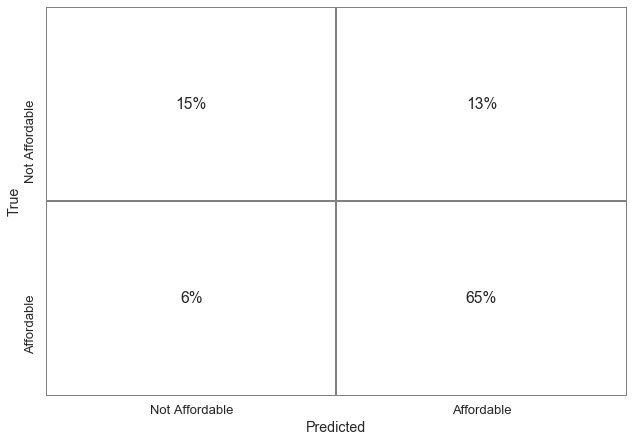

In [41]:
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set_context('talk')
matrix = pd.crosstab(Ytest, RFC_aff.predict(Xtest), normalize=True)
negative_class = 'Not Affordable'
positive_class = 'Affordable'
matrix.columns = [negative_class, positive_class]
matrix.index = [negative_class, positive_class]
matrix.columns.name = 'Predicted'
matrix.index.name = 'True'
sns.heatmap(matrix, cmap=ListedColormap(['white']), annot=True, fmt='.0%', linewidths=1, linecolor='grey', cbar=False)
plt.show()

In [42]:
from sklearn.externals import joblib
joblib.dump(RFC_aff,'model.pkl')

['model.pkl']

In [43]:
rfcc = joblib.load('model.pkl')

In [46]:
dl[dl.BATHS==6]

,CONTROL,CMSA,SMSA,NUNIT2,ELEV,SHARAT,SHARFR,GARAGE,PORCH,NOSTEP,...,COST12RELFMRCAT,COSTMEDRELAMIPCT,COSTMEDRELAMICAT,COSTMEDRELPOVPCT,COSTMEDRELPOVCAT,COSTMEDRELFMRPCT,COSTMEDRELFMRCAT,AFFORDABLE,CITY,TRUST
27407,402502130133,99,2160,1,-6,-6,-6,1,1,2,...,3,747.812813,7,2246.872799,4,1232.833028,3,0.0,Detroit,-6
28325,469258580141,99,6160,1,-6,-6,-6,2,2,2,...,2,32.855944,2,329.182896,4,50.263067,2,1.0,Philadelphia,Safe
